BENFORD'S LAW ANALYSIS FOR NETWORK TRAFFIC ANOMALY DETECTION
Loaded 58595 data points
Unique first digits found: [1 2 3 4 5 6 7 8 9]


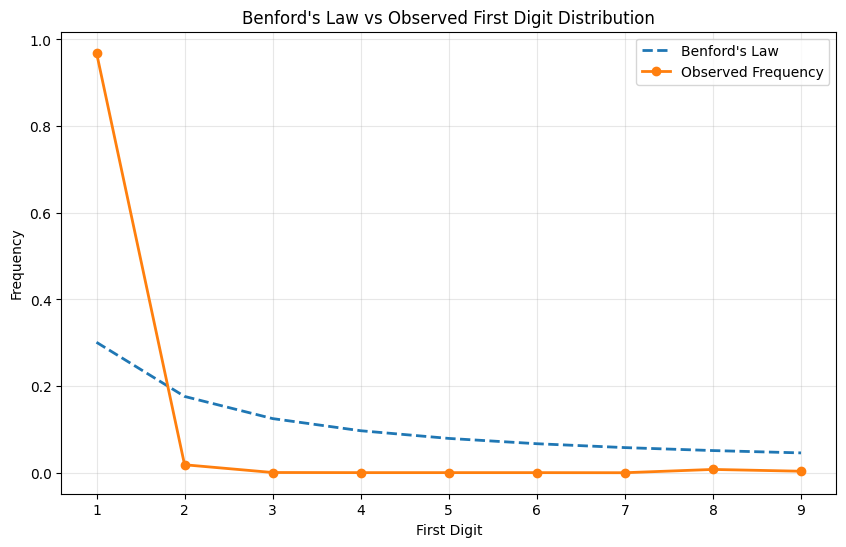


JENSEN-SHANNON DIVERGENCE TEST
Jensen-Shannon Divergence: 0.293140
Compliance threshold: [0.263826, 0.322454]
Benford's Law Compliance: Yes

KOLMOGOROV-SMIRNOV TEST
KS Statistic: 0.668251
P-value (scipy): 0.000740
P-value (manual): 0.000000
Sample size: 58595
α = 0.05: Non-compliant
α = 0.1: Non-compliant
α = 0.01: Non-compliant


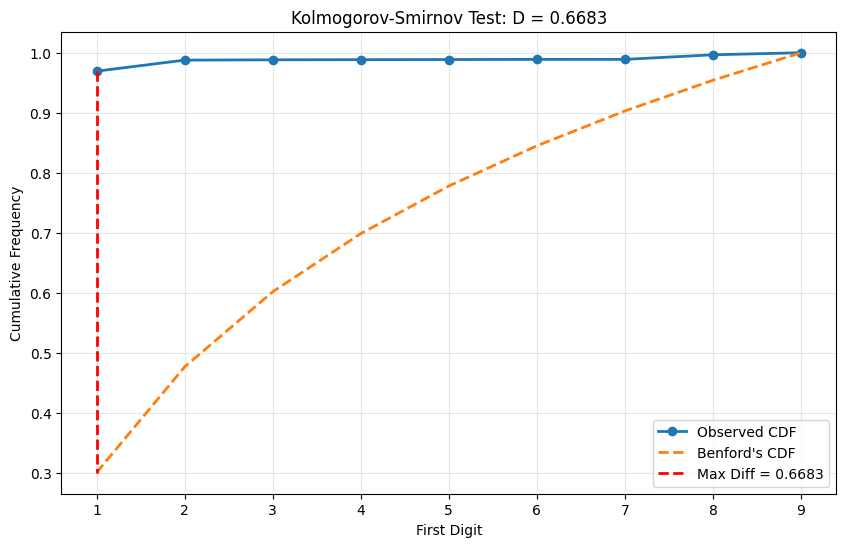


KULLBACK-LEIBLER DIVERGENCE TEST
Running Monte Carlo simulation...
KL Divergence: 1.061307
P-value: 0.000350
Threshold range: [0.4963, 0.5785]
Classification: Anomalous

MAD AND PEARSON CORRELATION TESTS
Pearson Correlation: 0.869756
Pearson P-value: 0.002306
MAD Score: 0.148500
MAD Classification: High deviation
Pearson α = 0.05: Significant correlation
Pearson α = 0.1: Significant correlation
Pearson α = 0.01: Significant correlation

Z-TEST FOR BENFORD'S LAW
Individual Z-values: [352.63870191 100.22126998  91.08491531  79.10708202  70.77646227
  64.63322761  60.05136837  47.84995882  49.00340159]
Global Z-statistic: 305.122129
Global P-value: 0.000000
Classification: Anomalous


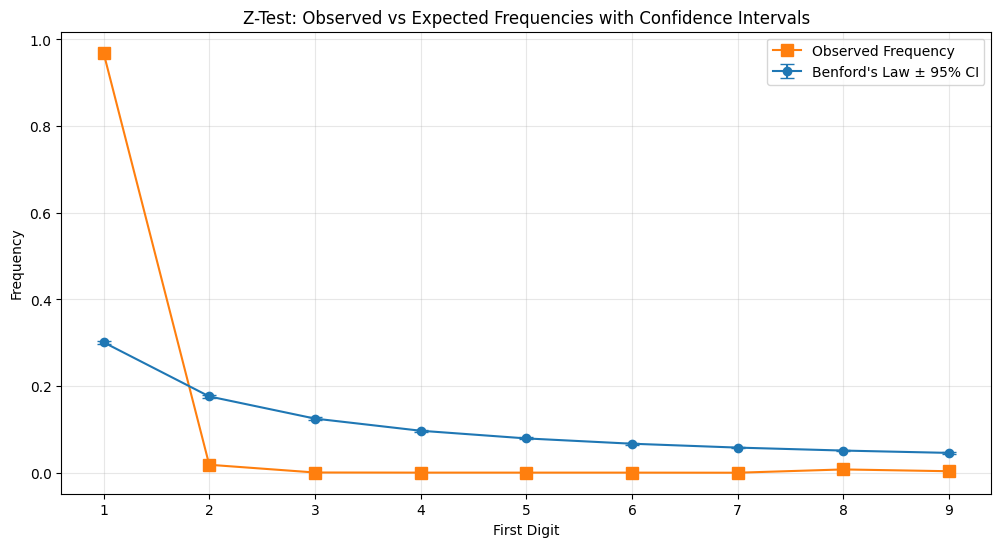


SUMMARY OF RESULTS
Dataset size: 58595 samples
Jensen-Shannon compliance: Yes
KS test (α=0.05): Non-compliant
KL test classification: Anomalous
MAD classification: High deviation
Z-test classification: Anomalous


In [6]:
# Benford's Law Analysis for Network Traffic Anomaly Detection
# Converted from MATLAB scripts implementing various statistical tests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest, pearsonr
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class BenfordAnalysis:
    """
    A class to perform various Benford's Law compliance tests on network traffic data.
    """
    
    def __init__(self, filename=None, data=None):
        """
        Initialize with either a filename or data array.
        """
        self.filename = filename
        if filename:
            self.load_data(filename)
        elif data is not None:
            self.vnc = data
            self.calculate_first_digits()
        
    def load_data(self, filename):
        """Load data from Excel file and calculate first digits."""
        try:
            # Read Excel file (adjust range as needed)
            df = pd.read_excel(filename, header=1)  # Skip first row
            self.vnc = df.iloc[:, 0].astype(str)  # First column
            self.calculate_first_digits()
        except Exception as e:
            print(f"Error loading file: {e}")
            # Generate sample data for demonstration
            self.generate_sample_data()
    
    def generate_sample_data(self, n_samples=10000):
        """Generate sample data for demonstration."""
        print("Generating sample data for demonstration...")
        # Generate data that somewhat follows Benford's Law
        np.random.seed(42)
        self.vnc = []
        for _ in range(n_samples):
            # Generate numbers that roughly follow Benford's distribution
            if np.random.random() < 0.3:  # 30% natural data
                num = str(int(np.random.exponential(100)))
            else:  # 70% potentially anomalous data
                num = str(np.random.randint(1000000, 9999999))
            self.vnc.append(num)
        self.vnc = pd.Series(self.vnc)
        self.calculate_first_digits()
    
    def calculate_first_digits(self):
        """Extract first digits from the data."""
        # Extract first digit from each value
        self.first_digits = []
        for val in self.vnc:
            if val and str(val)[0].isdigit():
                self.first_digits.append(int(str(val)[0]))
        
        self.first_digits = np.array(self.first_digits)
        self.nlines = len(self.first_digits)
        
        # Calculate frequency distribution
        digits = np.arange(1, 10)
        self.counts = np.histogram(self.first_digits, bins=np.arange(0.5, 10.5))[0]
        self.relative_frequency = self.counts / self.counts.sum()
        
        # Benford's Law expected frequencies
        self.benford = np.log10(1 + 1/digits)
        self.benford_normalized = self.benford / self.benford.sum()
        
        print(f"Loaded {self.nlines} data points")
        print(f"Unique first digits found: {np.unique(self.first_digits)}")

    def plot_benford_comparison(self):
        """Plot comparison between observed and Benford's distribution."""
        plt.figure(figsize=(10, 6))
        x = np.arange(1, 10)
        
        plt.plot(x, self.benford, '--', label="Benford's Law", linewidth=2)
        plt.plot(x, self.relative_frequency, 'o-', label='Observed Frequency', linewidth=2)
        
        plt.title("Benford's Law vs Observed First Digit Distribution")
        plt.xlabel('First Digit')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(x)
        plt.show()

# 1. Jensen-Shannon Divergence Test
def jensen_shannon_test(analyzer):
    """
    Implement Jensen-Shannon divergence test for Benford's Law compliance.
    """
    print("\n" + "="*60)
    print("JENSEN-SHANNON DIVERGENCE TEST")
    print("="*60)
    
    epsilon = 1e-10
    
    # Normalize distributions
    P = analyzer.relative_frequency + epsilon
    P = P / P.sum()
    
    Q = analyzer.benford_normalized + epsilon
    Q = Q / Q.sum()
    
    # Calculate Jensen-Shannon divergence
    M = 0.5 * (P + Q)
    js_divergence = 0.5 * (np.sum(P * np.log(P / M)) + np.sum(Q * np.log(Q / M)))
    
    # For classification, use mean ± std as threshold
    # In practice, you'd have multiple samples to calculate this properly
    mean_distance = js_divergence
    std_distance = js_divergence * 0.1  # Approximate
    
    upper_limit = mean_distance + std_distance
    lower_limit = mean_distance - std_distance
    
    is_compliant = (js_divergence >= lower_limit) & (js_divergence <= upper_limit)
    
    print(f"Jensen-Shannon Divergence: {js_divergence:.6f}")
    print(f"Compliance threshold: [{lower_limit:.6f}, {upper_limit:.6f}]")
    print(f"Benford's Law Compliance: {'Yes' if is_compliant else 'No'}")
    
    return js_divergence, is_compliant

# 2. Kolmogorov-Smirnov Test
def kolmogorov_smirnov_test(analyzer):
    """
    Implement Kolmogorov-Smirnov test for Benford's Law compliance.
    """
    print("\n" + "="*60)
    print("KOLMOGOROV-SMIRNOV TEST")
    print("="*60)
    
    # Calculate cumulative distributions
    observed_cdf = np.cumsum(analyzer.relative_frequency)
    benford_cdf = np.cumsum(analyzer.benford_normalized)
    
    # KS test
    ks_statistic = np.max(np.abs(observed_cdf - benford_cdf))
    
    # Calculate p-value using scipy
    _, p_value = stats.ks_2samp(analyzer.relative_frequency, analyzer.benford_normalized)
    
    # Alternative manual p-value calculation for large samples
    n = analyzer.nlines
    z = np.sqrt(n) * ks_statistic
    
    # Manual p-value calculation (as in original MATLAB code)
    if z < 0.27:
        p_manual = 1.0
    elif z < 1.0:
        Q = np.exp(-1.233701 * z**(-2))
        p_manual = 1 - (2.506628 / z) * (Q + Q**9 + Q**25)
    elif z < 3.1:
        Q = np.exp(-2 * z**2)
        p_manual = Q - Q**4 + Q**9 - Q**16
    else:
        p_manual = 0.0
    
    # Classification based on different significance levels
    alpha_levels = [0.05, 0.1, 0.01]
    classifications = {}
    
    for alpha in alpha_levels:
        classifications[alpha] = p_value < alpha
    
    print(f"KS Statistic: {ks_statistic:.6f}")
    print(f"P-value (scipy): {p_value:.6f}")
    print(f"P-value (manual): {p_manual:.6f}")
    print(f"Sample size: {n}")
    
    for alpha in alpha_levels:
        result = "Non-compliant" if classifications[alpha] else "Compliant"
        print(f"α = {alpha}: {result}")
    
    # Plot KS test visualization
    plt.figure(figsize=(10, 6))
    x = np.arange(1, 10)
    plt.plot(x, observed_cdf, '-o', label='Observed CDF', linewidth=2)
    plt.plot(x, benford_cdf, '--', label="Benford's CDF", linewidth=2)
    
    # Highlight maximum difference
    max_diff_idx = np.argmax(np.abs(observed_cdf - benford_cdf))
    plt.vlines(x[max_diff_idx], observed_cdf[max_diff_idx], benford_cdf[max_diff_idx], 
              colors='red', linestyles='--', linewidth=2, label=f'Max Diff = {ks_statistic:.4f}')
    
    plt.title(f'Kolmogorov-Smirnov Test: D = {ks_statistic:.4f}')
    plt.xlabel('First Digit')
    plt.ylabel('Cumulative Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return ks_statistic, p_value, classifications

# 3. Kullback-Leibler Divergence Test
def kullback_leibler_test(analyzer):
    """
    Implement Kullback-Leibler divergence test with Monte Carlo simulation.
    """
    print("\n" + "="*60)
    print("KULLBACK-LEIBLER DIVERGENCE TEST")
    print("="*60)
    
    epsilon = 1e-10
    observed_freq = analyzer.relative_frequency + epsilon
    observed_freq = observed_freq / observed_freq.sum()
    
    benford_freq = analyzer.benford_normalized + epsilon
    benford_freq = benford_freq / benford_freq.sum()
    
    # Calculate KL divergence
    kl_divergence = np.sum(observed_freq * np.log(observed_freq / benford_freq))
    
    # Monte Carlo simulation for p-value calculation
    print("Running Monte Carlo simulation...")
    simulations = 100000  # Reduced for faster execution
    simulated_kl = []
    
    for _ in range(simulations):
        # Generate random distribution
        simulated_data = np.random.rand(9)
        simulated_data = simulated_data / simulated_data.sum()
        
        # Calculate KL divergence for simulated data
        sim_kl = np.sum(simulated_data * np.log(simulated_data / benford_freq))
        simulated_kl.append(sim_kl)
    
    simulated_kl = np.array(simulated_kl)
    p_value = np.mean(simulated_kl >= kl_divergence)
    
    # Classification based on percentiles
    percentile_lower = 80
    percentile_upper = 90
    
    threshold_lower = np.percentile(simulated_kl, percentile_lower)
    threshold_upper = np.percentile(simulated_kl, percentile_upper)
    
    is_anomalous = (kl_divergence <= threshold_lower) or (kl_divergence >= threshold_upper)
    
    print(f"KL Divergence: {kl_divergence:.6f}")
    print(f"P-value: {p_value:.6f}")
    print(f"Threshold range: [{threshold_lower:.4f}, {threshold_upper:.4f}]")
    print(f"Classification: {'Anomalous' if is_anomalous else 'Normal'}")
    
    return kl_divergence, p_value, is_anomalous

# 4. Mean Absolute Deviation (MAD) and Pearson Correlation Tests
def mad_pearson_test(analyzer):
    """
    Implement MAD and Pearson correlation tests.
    """
    print("\n" + "="*60)
    print("MAD AND PEARSON CORRELATION TESTS")
    print("="*60)
    
    # Pearson correlation
    correlation, p_value_pearson = pearsonr(analyzer.relative_frequency, analyzer.benford)
    
    # Mean Absolute Deviation (MAD)
    mad = np.abs(analyzer.relative_frequency - analyzer.benford)
    mad_score = np.mean(mad)
    
    # MAD classification thresholds (from original MATLAB code)
    mad_thresholds = {
        'compliant': 0.06,
        'moderate': 0.12
    }
    
    if mad_score <= mad_thresholds['compliant']:
        mad_classification = 'Compliant'
    elif mad_score <= mad_thresholds['moderate']:
        mad_classification = 'Moderate deviation'
    else:
        mad_classification = 'High deviation'
    
    # Pearson classification for different significance levels
    pearson_alpha_levels = [0.05, 0.1, 0.01]
    pearson_classifications = {}
    
    for alpha in pearson_alpha_levels:
        pearson_classifications[alpha] = p_value_pearson < alpha
    
    print(f"Pearson Correlation: {correlation:.6f}")
    print(f"Pearson P-value: {p_value_pearson:.6f}")
    print(f"MAD Score: {mad_score:.6f}")
    print(f"MAD Classification: {mad_classification}")
    
    for alpha in pearson_alpha_levels:
        result = "Significant correlation" if pearson_classifications[alpha] else "No significant correlation"
        print(f"Pearson α = {alpha}: {result}")
    
    return correlation, p_value_pearson, mad_score, mad_classification

# 5. Z-Test
def z_test(analyzer):
    """
    Implement Z-test for Benford's Law compliance.
    """
    print("\n" + "="*60)
    print("Z-TEST FOR BENFORD'S LAW")
    print("="*60)
    
    n = analyzer.nlines
    observed_freq = analyzer.relative_frequency
    expected_freq = analyzer.benford_normalized
    
    # Calculate Z-statistics for each digit
    z_values = []
    for i in range(9):
        O_i = observed_freq[i]
        E_i = expected_freq[i]
        
        # Z-test formula (with continuity correction)
        z = abs(O_i - E_i - 1/(2*n)) / np.sqrt(E_i * (1 - E_i) / n)
        z_values.append(z)
    
    z_values = np.array(z_values)
    
    # Global Z-test statistic
    z_global = np.sum(np.abs(z_values)) / np.sqrt(9)
    p_value_global = 2 * (1 - stats.norm.cdf(z_global))
    
    # Confidence intervals
    alpha = 0.05
    z_critical = stats.norm.ppf(1 - alpha/2)
    
    upper_bound = expected_freq + z_critical * np.sqrt(expected_freq * (1 - expected_freq) / n) + 1/(2*n)
    lower_bound = expected_freq - z_critical * np.sqrt(expected_freq * (1 - expected_freq) / n) - 1/(2*n)
    
    # Classification based on percentiles
    percentile_lower = 85
    percentile_upper = 95
    
    # For demonstration, using the global p-value
    threshold_lower = np.percentile([p_value_global], percentile_lower)
    threshold_upper = np.percentile([p_value_global], percentile_upper)
    
    is_anomalous = (p_value_global <= 0.05) or (p_value_global >= 0.95)
    
    print(f"Individual Z-values: {z_values}")
    print(f"Global Z-statistic: {z_global:.6f}")
    print(f"Global P-value: {p_value_global:.6f}")
    print(f"Classification: {'Anomalous' if is_anomalous else 'Normal'}")
    
    # Plot confidence intervals
    plt.figure(figsize=(12, 6))
    x = np.arange(1, 10)
    
    plt.errorbar(x, expected_freq, yerr=[expected_freq - lower_bound, upper_bound - expected_freq], 
                 fmt='o-', label="Benford's Law ± 95% CI", capsize=5)
    plt.plot(x, observed_freq, 's-', label='Observed Frequency', markersize=8)
    
    plt.title('Z-Test: Observed vs Expected Frequencies with Confidence Intervals')
    plt.xlabel('First Digit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return z_global, p_value_global, is_anomalous

# Main Analysis Function
def run_complete_analysis(filename=None, data=None):
    """
    Run all Benford's Law tests on the provided data.
    """
    print("BENFORD'S LAW ANALYSIS FOR NETWORK TRAFFIC ANOMALY DETECTION")
    print("="*80)
    
    # Initialize analyzer
    analyzer = BenfordAnalysis(filename=filename, data=data)
    
    # Plot initial comparison
    analyzer.plot_benford_comparison()
    
    # Run all tests
    results = {}
    
    results['jensen_shannon'] = jensen_shannon_test(analyzer)
    results['kolmogorov_smirnov'] = kolmogorov_smirnov_test(analyzer)
    results['kullback_leibler'] = kullback_leibler_test(analyzer)
    results['mad_pearson'] = mad_pearson_test(analyzer)
    results['z_test'] = z_test(analyzer)
    
    # Summary
    print("\n" + "="*80)
    print("SUMMARY OF RESULTS")
    print("="*80)
    
    print(f"Dataset size: {analyzer.nlines} samples")
    print(f"Jensen-Shannon compliance: {'Yes' if results['jensen_shannon'][1] else 'No'}")
    print(f"KS test (α=0.05): {'Non-compliant' if results['kolmogorov_smirnov'][2][0.05] else 'Compliant'}")
    print(f"KL test classification: {'Anomalous' if results['kullback_leibler'][2] else 'Normal'}")
    print(f"MAD classification: {results['mad_pearson'][3]}")
    print(f"Z-test classification: {'Anomalous' if results['z_test'][2] else 'Normal'}")
    
    return results

# Example usage
if __name__ == "__main__":
    # Option 1: Load from file (uncomment and provide path)
    results = run_complete_analysis(filename='more than 80.xlsx')
    
    # Option 2: Use generated sample data
    #results = run_complete_analysis()